#### Library import

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

from matplotlib.ticker import FormatStrFormatter

import re
from tqdm import tqdm

2023-06-21 15:26:00.918076: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


#### GPU setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10*1024)])
    except RuntimeError as e:
        print(e)

#### Data import and preprocessing

In [62]:
data = pd.read_csv("../1.data/data.csv")
data.columns

Index(['OBJECTID_x', 'ID', 'pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope',
       'altitude', 'profile_curve', 'profile_c_num', 'profile_c_abs',
       'planform_curve', 'planform_c_num', 'planform_c_abs', 'HYDGRP',
       'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C', 'HYDGRP_D', 'ANION_EXCL', 'SOL_CRK',
       'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'SOL_EC1', 'distance'],
      dtype='object')

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OBJECTID_x      1458 non-null   int64  
 1   ID              1458 non-null   object 
 2   pH              1458 non-null   float64
 3   As              1458 non-null   float64
 4   Cd              1458 non-null   float64
 5   Ni              1458 non-null   float64
 6   Pb              757 non-null    float64
 7   Zn              337 non-null    object 
 8   Hg              1458 non-null   float64
 9   slope           1458 non-null   float64
 10  altitude        1458 non-null   float64
 11  profile_curve   1458 non-null   float64
 12  profile_c_num   1458 non-null   float64
 13  profile_c_abs   1458 non-null   int64  
 14  planform_curve  1458 non-null   float64
 15  planform_c_num  1458 non-null   float64
 16  planform_c_abs  1458 non-null   int64  
 17  HYDGRP          1458 non-null   o

In [64]:
data = data.drop(['OBJECTID_x','ID','HYDGRP','profile_c_num', 'profile_c_abs','planform_c_num', 'planform_c_abs','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)
data.columns

Index(['pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope', 'altitude',
       'profile_curve', 'planform_curve', 'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C',
       'HYDGRP_D', 'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'distance'],
      dtype='object')

In [65]:
#data.corr().min()

"""
pH               -0.099537
As               -0.075567
Cd               -0.191396
Ni               -0.178740
Pb               -0.334075
Hg               -0.038702
slope            -0.361145
altitude         -0.190516
profile_c_num    -0.075701
profile_c_abs    -0.268719
planform_c_num   -0.163494
planform_c_abs   -0.268719
HYDGRP_A         -0.879764
HYDGRP_B         -0.879764
HYDGRP_C         -0.331920
HYDGRP_D         -0.279327
SOL_K1           -0.361145
CLAY1            -0.705075
SILT1            -0.899352
SAND1            -0.899352
ROCK1            -0.538317
distance         -0.334075

"""
#data.corr()

'\npH               -0.099537\nAs               -0.075567\nCd               -0.191396\nNi               -0.178740\nPb               -0.334075\nHg               -0.038702\nslope            -0.361145\naltitude         -0.190516\nprofile_c_num    -0.075701\nprofile_c_abs    -0.268719\nplanform_c_num   -0.163494\nplanform_c_abs   -0.268719\nHYDGRP_A         -0.879764\nHYDGRP_B         -0.879764\nHYDGRP_C         -0.331920\nHYDGRP_D         -0.279327\nSOL_K1           -0.361145\nCLAY1            -0.705075\nSILT1            -0.899352\nSAND1            -0.899352\nROCK1            -0.538317\ndistance         -0.334075\n\n'

#### Eliminate outlier and train / test split

In [66]:
def eli_outlier(data, value):
    q1 = data[value].quantile(0.25)
    q3 = data[value].quantile(0.75)

    iqr = q3 - q1

    q1_condition = data[value] < q1-1.5*iqr
    q3_condition = data[value] > q3+1.5*iqr

    reset_q1_index = data[q1_condition].index
    reset_q3_index = data[q3_condition].index

    data.drop(reset_q1_index, inplace = True)
    data.drop(reset_q3_index, inplace = True)

    return data

In [67]:
As = eli_outlier(data, "As")
Cd = eli_outlier(data, "Cd")
Ni = eli_outlier(data, "Ni")

In [68]:
As = As.drop(["Cd", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Cd = Cd.drop(["As", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Ni = Ni.drop(["As", "Cd", "Pb", "Zn", "Hg"], axis = 1)

In [69]:
As_X = As.drop(["As"], axis=1)
Cd_X = Cd.drop(["Cd"], axis=1)
Ni_X = Ni.drop(["Ni"], axis=1)

As_y = As["As"]
Cd_y = Cd["Cd"]
Ni_y = Ni["Ni"]

In [70]:
As_y = np.log1p(As["As"])
Cd_y = np.log1p(Cd["Cd"])
Ni_y = np.log1p(Ni["Ni"])

StandardScaler

In [71]:
As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X, Ni_y, test_size=0.2, random_state=42)

In [72]:
from sklearn.preprocessing import StandardScaler

As_scaler = StandardScaler()
Cd_scaler = StandardScaler()
Ni_scaler = StandardScaler()

As_X_train = As_scaler.fit_transform(As_X_train)
Cd_X_train = Cd_scaler.fit_transform(Cd_X_train)
Ni_X_train = Ni_scaler.fit_transform(Ni_X_train)

As_X_test = As_scaler.transform(As_X_test)
Cd_X_test = Cd_scaler.transform(Cd_X_test)
Ni_X_test = Ni_scaler.transform(Ni_X_test)

MinMaxScaler

In [73]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# As_X_scaled = scaler.fit_transform(As_X)
# Cd_X_scaled = scaler.fit_transform(Cd_X)
# Ni_X_scaled = scaler.fit_transform(Ni_X)

# As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
# Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
# Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

Nothing~

In [74]:
# As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X, As_y, test_size=0.2, random_state=42)
# Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X, Cd_y, test_size=0.2, random_state=42)
# Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X, Ni_y, test_size=0.2, random_state=42)

#### 10-Fold Crossvalidation

In [75]:
#kf = KFold(n_splits = 10, random_state = 42, shuffle = True)

#### Optuna Optimization

In [76]:
import optuna

from optuna import Trial
from optuna.samplers import TPESampler

In [77]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR


def objectiveSVM(trial: Trial, X_train, y_train) -> float:
    C = trial.suggest_loguniform('C', 0.1, 100.0)
    epsilon = trial.suggest_loguniform('epsilon', 0.01, 1.0)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    degree = trial.suggest_int('degree', 1, 5)
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    model = SVR(C=C, epsilon=epsilon, kernel=kernel, degree=degree)

    r2 = cross_val_score(model, X_train, y_train, scoring='r2', cv=kf)
    r2 = r2.mean()

    return r2


####  Optimization

In [78]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="svm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveSVM(trial, As_X_train, As_y_train), n_trials=1000)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-06-22 13:13:45,958] A new study created in memory with name: svm_parameter_opt
[I 2023-06-22 13:13:50,049] Trial 0 finished with value: -0.012961434523946802 and parameters: {'C': 19.72425496258931, 'epsilon': 0.022768500952288193, 'kernel': 'linear', 'degree': 5}. Best is trial 0 with value: -0.012961434523946802.
[I 2023-06-22 13:13:50,176] Trial 1 finished with value: -0.1358373434560775 and parameters: {'C': 62.1912453050928, 'epsilon': 0.5110064254675649, 'kernel': 'rbf', 'degree': 4}. Best is trial 0 with value: -0.012961434523946802.
[I 2023-06-22 13:13:50,301] Trial 2 finished with value: 0.08254431740588002 and parameters: {'C': 0.1958879467130406, 'epsilon': 0.30478603379823355, 'kernel': 'rbf', 'degree': 2}. Best is trial 2 with value: 0.08254431740588002.
[I 2023-06-22 13:13:55,902] Trial 3 finished with value: -0.01168750177542539 and parameters: {'C': 29.621133365350303, 'epsilon': 0.03645357093994542, 'kernel': 'linear', 'degree': 1}. Best is trial 2 with value: 

Best r2:  0.08348845178966469
Best trial: {'C': 0.16642835563894615, 'epsilon': 0.3017120015808663, 'kernel': 'rbf', 'degree': 1}


In [79]:
optuna.visualization.plot_parallel_coordinate(study)

In [80]:
print("Best trial:", study.best_trial.params)

Best trial: {'C': 0.16642835563894615, 'epsilon': 0.3017120015808663, 'kernel': 'rbf', 'degree': 1}


In [81]:
svm_params = {
    "C": study.best_trial.params["C"],
    "epsilon": study.best_trial.params["epsilon"],
    "kernel": study.best_trial.params["kernel"],
    "degree": study.best_trial.params["degree"]
}

svm = SVR(**svm_params)
svm.fit(As_X_train, As_y_train)

SVR(C=0.16642835563894615, degree=1, epsilon=0.3017120015808663)

In [82]:
y_train_pred = svm.predict(As_X_train)
y_test_pred = svm.predict(As_X_test)

In [83]:
# plt.scatter(y_train_pred, np.array(As_y_train))

In [84]:
print("Train RMSE: ", np.sqrt(mean_squared_error(As_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(As_y_test, y_test_pred)))

Train RMSE:  0.33026996156225674
Test RMSE:  0.3596421797307866


In [85]:
print("Train R2: ", r2_score(As_y_train, y_train_pred))
print("Test R2: ", r2_score(As_y_test, y_test_pred))

Train R2:  0.18089982758694345
Test R2:  0.050684885715164274


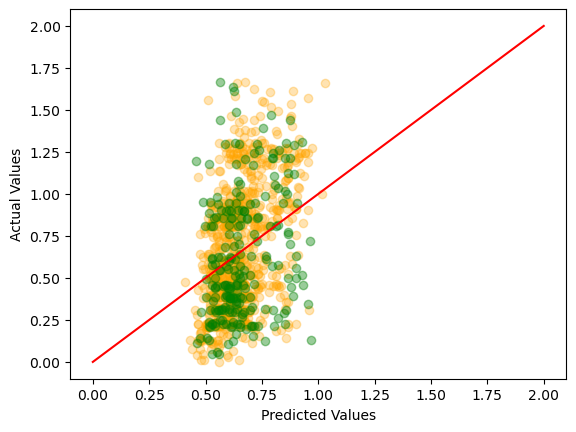

In [86]:
plt.scatter(y_train_pred, np.array(As_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(As_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 2.0], [0, 2.0], color='red', linestyle='-')

plt.show()

Cd

Optimization

In [87]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="svm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveSVM(trial, Cd_X_train, Cd_y_train), n_trials=1000)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-06-22 13:19:04,824] A new study created in memory with name: svm_parameter_opt
[I 2023-06-22 13:19:04,895] Trial 0 finished with value: -0.44208051467606574 and parameters: {'C': 40.364782682285544, 'epsilon': 0.10084423884766566, 'kernel': 'poly', 'degree': 3}. Best is trial 0 with value: -0.44208051467606574.
[I 2023-06-22 13:19:05,207] Trial 1 finished with value: -0.17002222350629728 and parameters: {'C': 0.9274100261158683, 'epsilon': 0.01817669489129773, 'kernel': 'rbf', 'degree': 1}. Best is trial 1 with value: -0.17002222350629728.
[I 2023-06-22 13:19:05,217] Trial 2 finished with value: -0.5094651841240979 and parameters: {'C': 26.01550652999551, 'epsilon': 0.6041967656703948, 'kernel': 'poly', 'degree': 3}. Best is trial 1 with value: -0.17002222350629728.
[I 2023-06-22 13:19:05,227] Trial 3 finished with value: -0.5094651841240979 and parameters: {'C': 48.61433743774688, 'epsilon': 0.6427436986132761, 'kernel': 'poly', 'degree': 1}. Best is trial 1 with value: -0.170

Best r2:  0.007291421924159991
Best trial: {'C': 43.810944851684845, 'epsilon': 0.07942959897058782, 'kernel': 'linear', 'degree': 4}


In [88]:
optuna.visualization.plot_parallel_coordinate(study)

In [89]:
print("Best trial:", study.best_trial.params)

Best trial: {'C': 43.810944851684845, 'epsilon': 0.07942959897058782, 'kernel': 'linear', 'degree': 4}


In [90]:
svm_params = {
    "C": study.best_trial.params["C"],
    "epsilon": study.best_trial.params["epsilon"],
    "kernel": study.best_trial.params["kernel"],
    "degree": study.best_trial.params["degree"]
}

svm = SVR(**svm_params)
svm.fit(Cd_X_train, Cd_y_train)

SVR(C=43.810944851684845, degree=4, epsilon=0.07942959897058782,
    kernel='linear')

In [91]:
y_train_pred = svm.predict(Cd_X_train)
y_test_pred = svm.predict(Cd_X_test)

In [92]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Cd_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Cd_y_test, y_test_pred)))

Train RMSE:  0.054628573252189755
Test RMSE:  0.05893022915186216


In [93]:
print("Train R2: ", r2_score(Cd_y_train, y_train_pred))
print("Test R2: ", r2_score(Cd_y_test, y_test_pred))

Train R2:  0.021668438607376994
Test R2:  0.0028387869595375426


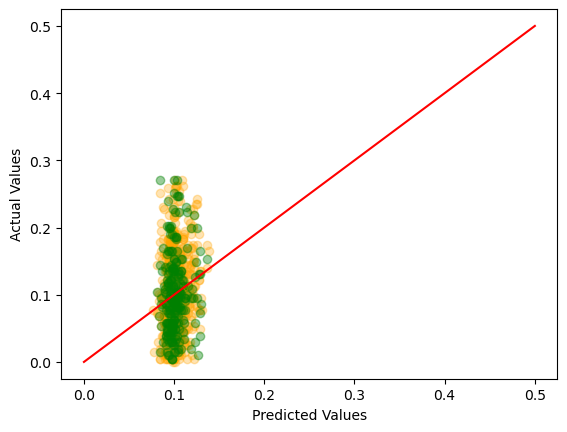

In [94]:
plt.scatter(y_train_pred, np.array(Cd_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Cd_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 0.5], [0, 0.5], color='red', linestyle='-')

plt.show()

Ni

In [95]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="svm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveSVM(trial, Ni_X_train, Ni_y_train), n_trials=1000)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-06-22 14:14:31,437] A new study created in memory with name: svm_parameter_opt
[I 2023-06-22 14:14:32,795] Trial 0 finished with value: 0.13547863881306754 and parameters: {'C': 8.462983199586564, 'epsilon': 0.14027387144407946, 'kernel': 'linear', 'degree': 4}. Best is trial 0 with value: 0.13547863881306754.
[I 2023-06-22 14:14:33,001] Trial 1 finished with value: 0.39226899188599373 and parameters: {'C': 1.637207591852024, 'epsilon': 0.4053038257179668, 'kernel': 'rbf', 'degree': 3}. Best is trial 1 with value: 0.39226899188599373.
[I 2023-06-22 14:14:33,801] Trial 2 finished with value: 0.29766799592213244 and parameters: {'C': 76.97942063048771, 'epsilon': 0.1891384139262334, 'kernel': 'rbf', 'degree': 5}. Best is trial 1 with value: 0.39226899188599373.
[I 2023-06-22 14:14:34,620] Trial 3 finished with value: 0.16241662028807063 and parameters: {'C': 7.12305147102301, 'epsilon': 0.633286939654983, 'kernel': 'linear', 'degree': 2}. Best is trial 1 with value: 0.39226899188

Best r2:  0.4392434180620051
Best trial: {'C': 9.786117535379578, 'epsilon': 0.3189041397522654, 'kernel': 'rbf', 'degree': 1}


In [96]:
optuna.visualization.plot_parallel_coordinate(study)

In [97]:
print("Best trial:", study.best_trial.params)

Best trial: {'C': 9.786117535379578, 'epsilon': 0.3189041397522654, 'kernel': 'rbf', 'degree': 1}


In [98]:
svm_params = {
    "C": study.best_trial.params["C"],
    "epsilon": study.best_trial.params["epsilon"],
    "kernel": study.best_trial.params["kernel"],
    "degree": study.best_trial.params["degree"]
}

svm = SVR(**svm_params)
svm.fit(Ni_X_train, Ni_y_train)

SVR(C=9.786117535379578, degree=1, epsilon=0.3189041397522654)

In [99]:
y_train_pred = svm.predict(Ni_X_train)
y_test_pred = svm.predict(Ni_X_test)

In [100]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Ni_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Ni_y_test, y_test_pred)))

Train RMSE:  0.6260577271302733
Test RMSE:  0.7916582833138962


In [101]:
print("Train R2: ", r2_score(Ni_y_train, y_train_pred))
print("Test R2: ", r2_score(Ni_y_test, y_test_pred))

Train R2:  0.6931589143958359
Test R2:  0.4979566477546967


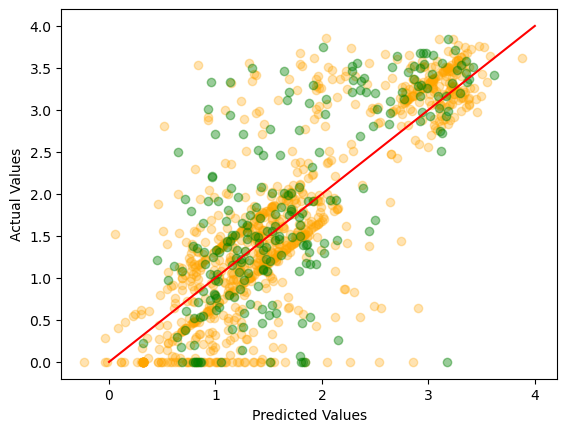

In [102]:
plt.scatter(y_train_pred, np.array(Ni_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Ni_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4.0], [0, 4.0], color='red', linestyle='-')

plt.show()